In [1]:
#%%

import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
# import ATARI
from ATARI.PiTFAll.performance_test import Performance_Test
from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
import h5py
import scipy.stats as sts

from scipy import integrate
import ATARI.utils.io.hdf5 as h5io

import ATARI.utils.atario as io
from ATARI.utils.misc import fine_egrid 
from ATARI.utils.io.experimental_parameters import BuildExperimentalParameters_fromDIRECT
from ATARI.utils.io.theoretical_parameters import BuildTheoreticalParameters_fromHDF5
from ATARI.utils.io.pointwise_container import BuildPointwiseContainer_fromHDF5
from ATARI.utils.io.data_container import BuildDataContainer_fromBUILDERS, BuildDataContainer_fromOBJECTS

In [2]:
%matplotlib widget

Text(0.5, 1.0, 'P-value Occurences for all LRTs')

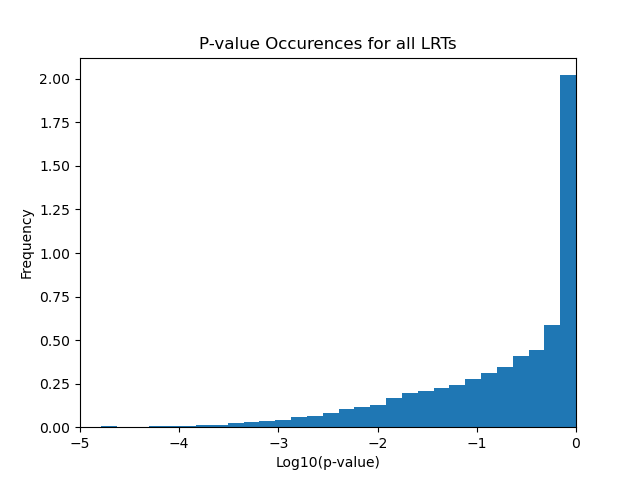

In [3]:

pvals = np.load('/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/Ta181_500samples_E75_125/pvals.npy')

figure()
hist(np.log10(pvals[pvals>0]), bins=100, density=True)
xlim([-5,0])
ylabel('Frequency')
xlabel('Log10(p-value)')
title("P-value Occurences for all LRTs")

In [4]:

#%% Initialize particle pair and quantup spin groups of interest

ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity [sic: perhaps, angular momentum?]
l_max = 1       # highest order l-wave to consider

spin_groups = [ (3.0,1,0) ] # (4.0,1,0) 
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':46.4, '4.0':35.5},
                                    'gn2'    :   {'3.0':64.0, '4.0':64.0}  })

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                spin_groups=spin_groups, average_parameters=average_parameters,
                                input_options={})

#%%

# initialize experimental setup
E_min_max = [75, 125]
input_options = { 'Add Noise': True,
            'Sample TURP':True,
            'Sample TOCS':True, 
            'Calculate Covariance': True,
            'Compression Points':[],
            'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.1024,    'unc'   :   0}}

exp = Experiment(E_min_max, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)

# %%
# run a performance test with the PiTFAll module

case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/Ta181_500samples_E75_125/Ta181_500samples_E75_125_1.hdf5'
# case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/TestFMReduction2.hdf5'

dataset_range = (0, 480)
input_options = {   'Overwrite Syndats'    :   False, 
                    'Overwrite Fits'       :   False,
                    'Use HDF5'             :   True,
                    'Vary Erange'          :   None} 

perf_test = Performance_Test(dataset_range,
                                case_file,
                                input_options=input_options)

# sample_data_df, out = perf_test.generate_syndats(Ta_pair, exp, 
#                                                     solver='syndat_SLBW')
# print(out)

#%%


# build experimental parameters
builder_exppar = BuildExperimentalParameters_fromDIRECT(0.067166, 0, 1e-2)
exppar = builder_exppar.construct()

# siglevels = [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.5]
# siglevels = np.linspace(0.001, 0.9, 50)
siglevels = np.logspace(-4,-2, 10)
siglevels[0] = np.round(siglevels[0], 4)
# siglevels = np.concatenate( [siglevels, np.linspace(0.001, 0.9, 50)] )

residual_dict = {}
Gg_dict = {}
Gn_dict = {}
for sig in siglevels:
    sig_str = str(sig).split('.')[1][0:7]
    residual_dict[sig_str]= []
    Gg_dict[sig_str] = []
    Gn_dict[sig_str] = []
Gg_dict['true'] = []
Gn_dict['true'] = []

for isample in range(0,480):

    # build true model parameter object
    builder_theopar = BuildTheoreticalParameters_fromHDF5('true', case_file, isample, Ta_pair)
    truepar = builder_theopar.construct()

    # build pointwise data 
    builder_pw = BuildPointwiseContainer_fromHDF5(case_file, isample)
    pw = builder_pw.construct_full()

    builder_dc = BuildDataContainer_fromOBJECTS( pw, exppar, [truepar])
    dc = builder_dc.construct()

    for sig in siglevels:
        sig_str = str(sig).split('.')[1][0:7]
        est_par_builder = BuildTheoreticalParameters_fromHDF5(f'par_est_{isample}_pv_{sig_str}', case_file, isample, Ta_pair)
        est_par = est_par_builder.construct()
        dc.add_theoretical_parameters(est_par)

    dc.models_to_pw()

    for sig in siglevels:
        sig_str = str(sig).split('.')[1][0:7]
        residual_dict[sig_str].append( np.array(dc.pw.fine[f'par_est_{isample}_pv_{sig_str}_xs']-dc.pw.fine.true_xs) )
        Gg_dict[sig_str].extend(list(dc.theoretical_parameters[f'par_est_{isample}_pv_{sig_str}'].resonance_ladder.Gg))
        Gn_dict[sig_str].extend(list(dc.theoretical_parameters[f'par_est_{isample}_pv_{sig_str}'].resonance_ladder.Gnx))
    
    Gg_dict['true'].extend(list(dc.theoretical_parameters['true'].resonance_ladder.Gg))
    Gn_dict['true'].extend(list(dc.theoretical_parameters['true'].resonance_ladder.Gnx))

    print(f"Completed sample: {isample}")
    # print(dc.pw.fine_columns)


Model 'true' already exists in pw.exp, bypassing pointwise reconstruction
Model 'true' already exists in pw.fine, bypassing pointwise reconstruction
Completed sample: 0
Model 'true' already exists in pw.exp, bypassing pointwise reconstruction
Model 'true' already exists in pw.fine, bypassing pointwise reconstruction
Completed sample: 1
Model 'true' already exists in pw.exp, bypassing pointwise reconstruction
Model 'true' already exists in pw.fine, bypassing pointwise reconstruction
Completed sample: 2
Model 'true' already exists in pw.exp, bypassing pointwise reconstruction
Model 'true' already exists in pw.fine, bypassing pointwise reconstruction
Completed sample: 3
Model 'true' already exists in pw.exp, bypassing pointwise reconstruction
Model 'true' already exists in pw.fine, bypassing pointwise reconstruction
Completed sample: 4
Model 'true' already exists in pw.exp, bypassing pointwise reconstruction
Model 'true' already exists in pw.fine, bypassing pointwise reconstruction
Comple

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1567, in H5F_open
    unable to lock the file
  File "H5FD.c", line 1640, in H5FD_lock
    driver lock request failed
  File "H5FDsec2.c", line 959, in H5FD_sec2_lock
    unable to lock file, errno = 35, error message = 'Resource temporarily unavailable'

End of HDF5 error back trace

Unable to open/create file '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/Ta181_500samples_E75_125/Ta181_500samples_E75_125_1.hdf5'

Text(0.5, 1.0, 'Uninformed Feature Bank')

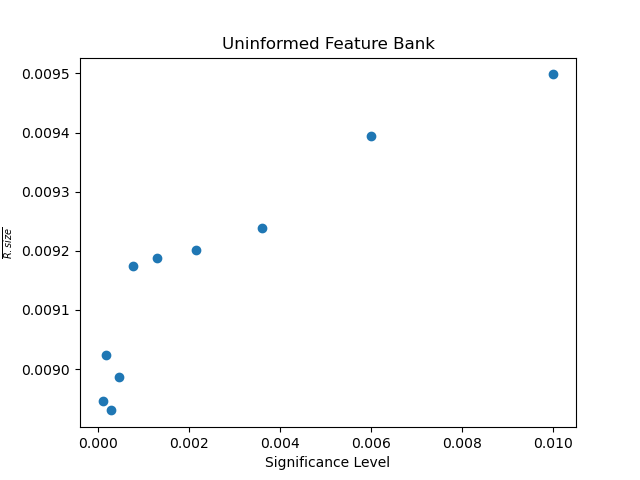

In [5]:

fnns = []
for sig in siglevels:
    sig_str = str(sig).split('.')[1][0:7]
    residual_matrix = np.array(residual_dict[sig_str])

    fnorm = np.linalg.norm(residual_matrix)
    fnorm_normed = fnorm/residual_matrix.size
    fnns.append(fnorm_normed)

    # print()
    # print(sig)
    # print(fnorm)
    # print(fnorm_normed)

# %%

figure()
plot(siglevels, fnns, 'o')
xlabel('Significance Level')
ylabel(r'$\frac{||R||_F}{R.size}$')
title('Uninformed Feature Bank')



In [6]:
sig_level_strings = [str(sig).split('.')[1][0:7] for sig in siglevels]

In [10]:
dof, mean, scale = sts.chi2.fit(target, floc=0)

print(dof, scale*dof)

6.652929093543934 76.67650268717155


Text(0.5, 1.0, 'True: (63.9721, 1000.00)\nEst:  (76.6765, 6.65)')

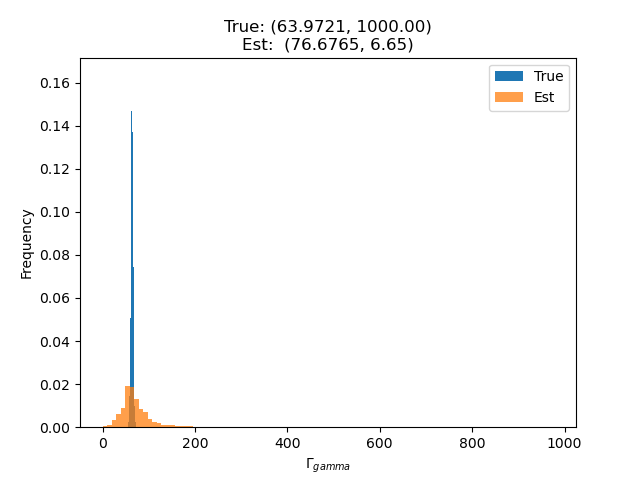

In [16]:
target = np.array(Gg_dict[sig_level_strings[0]])[np.array(Gg_dict[sig_level_strings[0]])<1000]
bins = 100

dof, loc, scale = sts.chi2.fit(target, floc=0)

figure()
out = hist(Gg_dict['true'], density=True, bins = bins, alpha=1, label="True")
out = hist(target, density=True, bins = bins, alpha=0.75, label="Est")
# xlim([0,150])
legend()
xlabel(r"$\Gamma_{gamma}$")
ylabel('Frequency')
title(f"True: ({np.mean(Gg_dict['true']):.4f}, 1000.00)\nEst:  ({scale*dof:<.4f}, {dof:0.2f})" )


0.8036918607136492


(1.7218750000000018, 0.8036918607136492, 1)

Text(0.5, 1.0, 'True: (1.6035, 1.00)\nEst:  (0.8037, 1.72)')

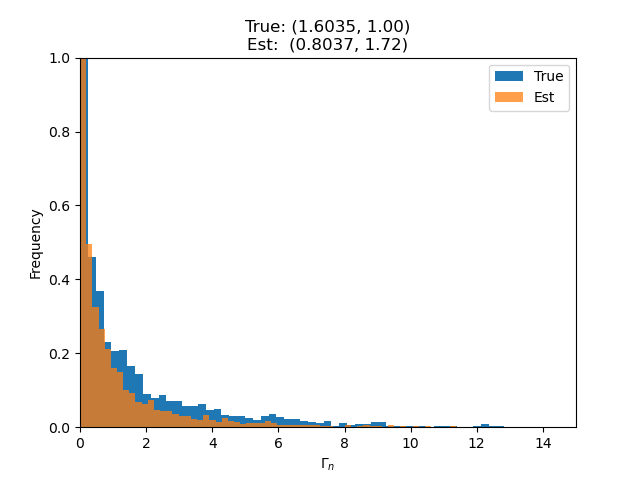

In [ ]:
target = np.array(Gn_dict[sig_level_strings[0]])[np.array(Gn_dict[sig_level_strings[0]])<100000]
bins = 100

mean = np.mean(target)
dof, mean, scale = sts.chi2.fit(target, floc=mean, fscale=1)

figure()
out = hist(Gn_dict['true'], density=True, bins = bins, alpha=1, label='True')
out = hist(target, density=True, bins = bins, alpha=0.75, label='Est')
xlim([0,15])
ylim([0,1])

legend()
xlabel(r"$\Gamma_{n}$")
ylabel('Frequency')
title(f"True: ({np.mean(Gn_dict['true']):.4f}, 1.00)\nEst:  ({np.mean(target):<.4f}, {dof:0.2f})" )

# Gg_dict[sig_level_strings[0]]
# np.shape(np.array(Gg_dict[sig_level_strings[0]]))

In [ ]:
dof

NameError: name 'dof' is not defined